## @Trump on Twitter and Financial Market Volatility
In this assignment, we mine the tweets of the president of America - Donald Trump by sentiment analysis, and try to correlate it with the VIX index, also known as the *fear* index and capturing market volatility.

Note: this notebook is modified from Tutorial 2 notebook. I rewrote a few inefficient loops for conciseness and performance.

In [1]:
import pandas as pd
from nltk.corpus import stopwords
import re
from scipy.stats import t as t_dist
import numpy as np
import matplotlib.pyplot as plt
import nltk
from matplotlib import style
import topicmodels

In [2]:
style.use('seaborn')

Trump's tweets are retrieved from [here](https://www.kaggle.com/jared4robertson/trumptweets). The original corpus contains large amount of URLs as pictures or hyperlinks in the tweets. We cleaned those URLs from the corpus. We encountered the same problem as the tutorial notebook: the text data appear to be encoded in non-UTF8 format. After some experiment, the text could be correctly decoded with `windows-1252`. It turned out that the FOMC files should be decoded with this format as well.

In [3]:
# Load Trump's tweets
tweets = pd.read_csv('TrumpTweets.csv', encoding='windows-1252', parse_dates=['created_at'])
tweets = tweets.sort_values('created_at').dropna(subset=['created_at'])

# Remove url
tweets.text = tweets.text.map(lambda text: re.sub(r'http\S+', '', text))

Then individual tweets were grouped on a daily basis. All tweets in a single day will be joined together to form a document.

In [4]:
daily_tweets = tweets[['text', 'created_at']].groupby(pd.Grouper(key='created_at', freq='D')).apply(lambda x: x.text.values)
daily_tweets = daily_tweets[daily_tweets.map(lambda x: len(x)) != 0]  # Remove days with no tweets
daily_tweets.head()

created_at
2009-05-04    [Be sure to tune in and watch Donald Trump on ...
2009-05-05    [Donald Trump will be appearing on The View to...
2009-05-08    [Donald Trump reads Top Ten Financial Tips on ...
2009-05-12    [My persona will never be that of a wallflower...
2009-05-13    [Listen to an interview with Donald Trump disc...
dtype: object

We select the period covering Trump's presidency. According to [wikipedia](https://en.wikipedia.org/wiki/Presidency_of_Donald_Trump), his presidency started on Jan 20, 2017, and the last available tweet in the dataset is on Dec 05, 2019.

In [5]:
TRUMP_PRESIDENCY_START = '2017-01-20'
# Select only tweets in his presidency
daily_tweets = daily_tweets.loc[TRUMP_PRESIDENCY_START:]
daily_tweets.head()

created_at
2017-01-20    [Thank you for joining us at the Lincoln Memor...
2017-01-21    [THANK YOU for another wonderful evening in Wa...
2017-01-22    [Had a great meeting at CIA Headquarters yeste...
2017-01-23    [Busy week planned with a heavy focus on jobs ...
2017-01-24    [Will be meeting at 9:00 with top automobile e...
dtype: object

## Topicmodels Package Preprocessing

In [6]:
texts=[]
for d, twts in daily_tweets.iteritems():
    text=' '.join(list(twts))
    texts.append(text)

#Show part of the corpus
print((texts[0])[:100])

Thank you for joining us at the Lincoln Memorial tonight- a very special evening! Together we are go


In [7]:
# creates object for pre-processing
objs=topicmodels.RawDocs(texts,'long')
# length of the example
print(len(objs.tokens))
# take the list and only show the first 50 tokens
print((objs.tokens[0])[:50])

1012
['thank', 'you', 'for', 'joining', 'us', 'at', 'the', 'lincoln', 'memorial', 'tonight', '-', 'a', 'very', 'special', 'evening', '!', 'together', 'we', 'are', 'going', 'to', 'make', 'am', '…', 'thank', 'you', 'for', 'a', 'wonderful', 'evening', 'in', 'washington', 'd', '.', 'c', '.', '#', 'inauguration', 'it', 'all', 'begins', 'today', '!', 'i', 'will', 'see', 'you', 'at', '11', ':']


In [8]:
objs.token_clean(1)
objs.tokens[1][:30] # first thirty tokens of second day's tweets

['thank',
 'you',
 'for',
 'another',
 'wonderful',
 'evening',
 'in',
 'washington',
 'together',
 'we',
 'will',
 'make',
 'america',
 'great',
 'again',
 'fantastic',
 'day',
 'and',
 'evening',
 'in',
 'washington',
 'thank',
 'you',
 'to',
 'foxnews',
 'and',
 'so',
 'many',
 'other',
 'news']

It is instructive to keep track of the dimensionality of the data as we go through different pre-processing steps.

In [9]:
all_stems = [s for d in objs.tokens for s in d]
print('number of unique tokens = '+str(len(set(all_stems))))
print('number of total tokens = '+str(len(all_stems)))

number of unique tokens = 13713
number of total tokens = 308165


The next step in pre-processing is to remove stopwords, which here have been defined by the "long" argument to RawDocs above.

In [10]:
objs.stopwords # the stopwords removed in this example

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'another',
 'any',
 'are',
 'as',
 'at',
 'back',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'down',
 'during',
 'each',
 'even',
 'ever',
 'every',
 'few',
 'first',
 'five',
 'for',
 'four',
 'from',
 'further',
 'get',
 'go',
 'goes',
 'had',
 'has',
 'have',
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'high',
 'him',
 'himself',
 'his',
 'how',
 'however',
 'i',
 'if',
 'in',
 'into',
 'is',
 'it',
 'its',
 'itself',
 'just',
 'least',
 'less',
 'like',
 'long',
 'made',
 'make',
 'many',
 'me',
 'more',
 'most',
 'my',
 'myself',
 'never',
 'new',
 'no',
 'nor',
 'not',
 'now',
 'of',
 'off',
 'old',
 'on',
 'once',
 'one',
 'only',
 'or',
 'other',
 'ought',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'put',
 'said',
 'same',
 'say',
 'says',
 'second',
 'see',
 

In [11]:
objs.stopword_remove("tokens")
all_stems = [s for d in objs.tokens for s in d]
print('number of unique tokens = '+str(len(set(all_stems))))
print('number of total tokens = '+str(len(all_stems)))

number of unique tokens = 13550
number of total tokens = 167784


In [12]:
objs.stem()
objs.stopword_remove("stems") # remove stems that are on the stopword list
all_stems = [s for d in objs.tokens for s in d]
print('number of unique tokens = '+str(len(set(all_stems))))
print('number of total tokens = '+str(len(all_stems)))

number of unique tokens = 13550
number of total tokens = 167784


## NLTK Module Preprocessing

In [13]:
#Import the necessary NLTK module and sklearn module 
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

Define a function for preprocessing procedures. In this function, we should
- remove the non-alphabetic tokens contents
- tokenize the text
- remove stopping words
- stem words

In [14]:
def mypreprocess(text, porter=True):
    text=text.lower()
    text=re.sub(r'[^a-z]+',' ',text)
    #tokenize the words
    token1=word_tokenize(text)
    token2=[t for t in token1 if t not in stopwords.words('english')]
    #stemming transformation
    if porter:
        token3=[PorterStemmer().stem(t) for t in token2]
    else:
        token3=[LancasterStemmer().stem(t) for t in token2]
    return token3

In [15]:
file_list=[]
Token=[]
for d, twts in daily_tweets.iteritems():
    text=' '.join(twts)  # Dirty document
    token3=mypreprocess(text)
    Token.append(token3)
    new_text=' '.join(token3) # Clean document
    file_list.append(new_text)
    print(f'Processing tweets on date {d}')

Processing tweets on date 2017-01-20 00:00:00
Processing tweets on date 2017-01-21 00:00:00
Processing tweets on date 2017-01-22 00:00:00
Processing tweets on date 2017-01-23 00:00:00
Processing tweets on date 2017-01-24 00:00:00
Processing tweets on date 2017-01-25 00:00:00
Processing tweets on date 2017-01-26 00:00:00
Processing tweets on date 2017-01-27 00:00:00
Processing tweets on date 2017-01-28 00:00:00
Processing tweets on date 2017-01-29 00:00:00
Processing tweets on date 2017-01-30 00:00:00
Processing tweets on date 2017-01-31 00:00:00
Processing tweets on date 2017-02-01 00:00:00
Processing tweets on date 2017-02-02 00:00:00
Processing tweets on date 2017-02-03 00:00:00
Processing tweets on date 2017-02-04 00:00:00
Processing tweets on date 2017-02-05 00:00:00
Processing tweets on date 2017-02-06 00:00:00
Processing tweets on date 2017-02-07 00:00:00
Processing tweets on date 2017-02-08 00:00:00
Processing tweets on date 2017-02-09 00:00:00
Processing tweets on date 2017-02-

Processing tweets on date 2017-07-22 00:00:00
Processing tweets on date 2017-07-23 00:00:00
Processing tweets on date 2017-07-24 00:00:00
Processing tweets on date 2017-07-25 00:00:00
Processing tweets on date 2017-07-26 00:00:00
Processing tweets on date 2017-07-27 00:00:00
Processing tweets on date 2017-07-28 00:00:00
Processing tweets on date 2017-07-29 00:00:00
Processing tweets on date 2017-07-30 00:00:00
Processing tweets on date 2017-07-31 00:00:00
Processing tweets on date 2017-08-01 00:00:00
Processing tweets on date 2017-08-02 00:00:00
Processing tweets on date 2017-08-03 00:00:00
Processing tweets on date 2017-08-04 00:00:00
Processing tweets on date 2017-08-05 00:00:00
Processing tweets on date 2017-08-06 00:00:00
Processing tweets on date 2017-08-07 00:00:00
Processing tweets on date 2017-08-08 00:00:00
Processing tweets on date 2017-08-09 00:00:00
Processing tweets on date 2017-08-10 00:00:00
Processing tweets on date 2017-08-11 00:00:00
Processing tweets on date 2017-08-

Processing tweets on date 2018-01-20 00:00:00
Processing tweets on date 2018-01-21 00:00:00
Processing tweets on date 2018-01-22 00:00:00
Processing tweets on date 2018-01-23 00:00:00
Processing tweets on date 2018-01-24 00:00:00
Processing tweets on date 2018-01-25 00:00:00
Processing tweets on date 2018-01-26 00:00:00
Processing tweets on date 2018-01-27 00:00:00
Processing tweets on date 2018-01-28 00:00:00
Processing tweets on date 2018-01-29 00:00:00
Processing tweets on date 2018-01-31 00:00:00
Processing tweets on date 2018-02-01 00:00:00
Processing tweets on date 2018-02-02 00:00:00
Processing tweets on date 2018-02-03 00:00:00
Processing tweets on date 2018-02-04 00:00:00
Processing tweets on date 2018-02-05 00:00:00
Processing tweets on date 2018-02-06 00:00:00
Processing tweets on date 2018-02-07 00:00:00
Processing tweets on date 2018-02-08 00:00:00
Processing tweets on date 2018-02-09 00:00:00
Processing tweets on date 2018-02-10 00:00:00
Processing tweets on date 2018-02-

Processing tweets on date 2018-08-17 00:00:00
Processing tweets on date 2018-08-18 00:00:00
Processing tweets on date 2018-08-19 00:00:00
Processing tweets on date 2018-08-20 00:00:00
Processing tweets on date 2018-08-21 00:00:00
Processing tweets on date 2018-08-22 00:00:00
Processing tweets on date 2018-08-23 00:00:00
Processing tweets on date 2018-08-24 00:00:00
Processing tweets on date 2018-08-25 00:00:00
Processing tweets on date 2018-08-26 00:00:00
Processing tweets on date 2018-08-27 00:00:00
Processing tweets on date 2018-08-28 00:00:00
Processing tweets on date 2018-08-29 00:00:00
Processing tweets on date 2018-08-30 00:00:00
Processing tweets on date 2018-08-31 00:00:00
Processing tweets on date 2018-09-01 00:00:00
Processing tweets on date 2018-09-02 00:00:00
Processing tweets on date 2018-09-03 00:00:00
Processing tweets on date 2018-09-04 00:00:00
Processing tweets on date 2018-09-05 00:00:00
Processing tweets on date 2018-09-06 00:00:00
Processing tweets on date 2018-09-

Processing tweets on date 2019-02-14 00:00:00
Processing tweets on date 2019-02-15 00:00:00
Processing tweets on date 2019-02-16 00:00:00
Processing tweets on date 2019-02-17 00:00:00
Processing tweets on date 2019-02-18 00:00:00
Processing tweets on date 2019-02-19 00:00:00
Processing tweets on date 2019-02-20 00:00:00
Processing tweets on date 2019-02-21 00:00:00
Processing tweets on date 2019-02-22 00:00:00
Processing tweets on date 2019-02-23 00:00:00
Processing tweets on date 2019-02-24 00:00:00
Processing tweets on date 2019-02-25 00:00:00
Processing tweets on date 2019-02-26 00:00:00
Processing tweets on date 2019-02-27 00:00:00
Processing tweets on date 2019-02-28 00:00:00
Processing tweets on date 2019-03-01 00:00:00
Processing tweets on date 2019-03-02 00:00:00
Processing tweets on date 2019-03-03 00:00:00
Processing tweets on date 2019-03-04 00:00:00
Processing tweets on date 2019-03-05 00:00:00
Processing tweets on date 2019-03-06 00:00:00
Processing tweets on date 2019-03-

Processing tweets on date 2019-08-13 00:00:00
Processing tweets on date 2019-08-14 00:00:00
Processing tweets on date 2019-08-15 00:00:00
Processing tweets on date 2019-08-16 00:00:00
Processing tweets on date 2019-08-17 00:00:00
Processing tweets on date 2019-08-18 00:00:00
Processing tweets on date 2019-08-19 00:00:00
Processing tweets on date 2019-08-20 00:00:00
Processing tweets on date 2019-08-21 00:00:00
Processing tweets on date 2019-08-22 00:00:00
Processing tweets on date 2019-08-23 00:00:00
Processing tweets on date 2019-08-24 00:00:00
Processing tweets on date 2019-08-25 00:00:00
Processing tweets on date 2019-08-26 00:00:00
Processing tweets on date 2019-08-27 00:00:00
Processing tweets on date 2019-08-28 00:00:00
Processing tweets on date 2019-08-29 00:00:00
Processing tweets on date 2019-08-30 00:00:00
Processing tweets on date 2019-08-31 00:00:00
Processing tweets on date 2019-09-01 00:00:00
Processing tweets on date 2019-09-02 00:00:00
Processing tweets on date 2019-09-

Generate a data frame in python to store the main preprocessed text information. We have completed the preprocessing task.

In [16]:
Date=daily_tweets.index
# Whole string of cleaned text (untokenized)
final=pd.DataFrame({'Date':Date,'Transformed Text':file_list})
final

,Date,Transformed Text
0,2017-01-20,thank join us lincoln memori tonight special e...
1,2017-01-21,thank anoth wonder even washington c togeth ma...
2,2017-01-22,great meet cia headquart yesterday pack hous p...
3,2017-01-23,busi week plan heavi focu job nation secur top...
4,2017-01-24,meet top automobil execut concern job america ...
...,...,...
1007,2019-12-01,sen tim scott say trump innoc way senat convic...
1008,2019-12-02,donald trump frame back mariabartiromo correct...
1009,2019-12-03,true unit state america support brave peopl ir...
1010,2019-12-04,enjoy meet prime minist borisjohnson unit king...


## Generate corpus **document-term matrices**

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#### Count Vectorization
In the first example, we vectorize the corpus by the **raw count** of the preprocessed text. CountVectorizer is to set up the properties of the vectorization. fit_transform is to transform the data. If want to know more, go 'help(CountVectorize)' in python

`min_df` is a parameter to limit the number of features. If the document frequency of features is lower than 0.1 documents in the corpus, it won't be considered. `stop_words` option specifies the stop word list used in this model. In this case, we use the nltk default stop word list.

In [18]:
tf=CountVectorizer(min_df=0.1,stop_words=stopwords.words('english'))
tf1=tf.fit_transform(file_list)

Then, we display the main attributes of the Vectorized corpus.

In [19]:
print(tf1.shape);
print(list(tf.get_feature_names())[0:20])   # The feature vectors
print(list(tf.stop_words_)[0:20])  # Rare words that are droped

(1012, 266)
['act', 'administr', 'agre', 'allow', 'alreadi', 'also', 'alway', 'america', 'american', 'amp', 'announc', 'anoth', 'approv', 'ask', 'back', 'bad', 'beauti', 'becom', 'believ', 'best']
['life', 'indirectli', 'bl', 'federalist', 'zte', 'properli', 'doonbeg', 'rever', 'dump', 'obsolet', 'ronjohnsonwi', 'unmask', 'bludgeon', 'ideolog', 'inclus', 'birthplac', 'farmbil', 'inaugurationday', 'li', 'takedown']


Then, we used `tfidf` weighting to compute the document-term matrix. `tfidf` increases the significance (frequency) of terms that appear just in few documents, relative to those appearing in almost every document. Recall that

$\mathrm{tfidf(t, d)} = \mathrm{tf}(t, d) \times (\log(\frac{n}{\mathrm{df(t)}})+1)$


In [20]:
# max_df ignores terms with document frequency higher than the given threshold
tfidf=TfidfVectorizer(min_df=0.1,max_df=0.9,stop_words=stopwords.words('english'))
tfidf1=tfidf.fit_transform(file_list)

In [21]:
print(tfidf1.shape);
print(list(tfidf.get_feature_names())[0:20])
print(len(tfidf.get_feature_names()))
print(list(tfidf.stop_words_)[0:20])

(1012, 266)
['act', 'administr', 'agre', 'allow', 'alreadi', 'also', 'alway', 'america', 'american', 'amp', 'announc', 'anoth', 'approv', 'ask', 'back', 'bad', 'beauti', 'becom', 'believ', 'best']
266
['life', 'indirectli', 'bl', 'federalist', 'zte', 'properli', 'doonbeg', 'rever', 'dump', 'obsolet', 'ronjohnsonwi', 'unmask', 'bludgeon', 'ideolog', 'inclus', 'birthplac', 'farmbil', 'inaugurationday', 'li', 'takedown']


We can check the Document-Term matrix.

In [22]:
print(tf1.toarray())
print(tfidf1.toarray())

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 1 2 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 5 0 0]
 [0 0 0 ... 0 0 1]]
[[0.         0.09284201 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.18715614 ... 0.10447493 0.37329778 0.        ]
 ...
 [0.         0.35684629 0.         ... 0.         0.         0.        ]
 [0.         0.         0.12038587 ... 0.33601102 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.43429207]]


We visualized the popularity of terms in Trump's tweets. A naive way is to **aggregate the Document-Term matrix by columns.**

Note that `numpy` provides an aggreagate-along-axis function, which should be much faster than homemade loops.

In [23]:
Count = pd.DataFrame(data=dict(Term=tf.get_feature_names(),
                               Count=np.sum(tf1.toarray(),
                                            axis=0))).sort_values('Count', ascending=False)
Count.reset_index(drop=True).head(20)

,Term,Count
0,great,2412
1,rt,2283
2,amp,1861
3,presid,1393
4,democrat,1293
5,peopl,1216
6,countri,1107
7,trump,1034
8,state,942
9,get,936


We played the same trick in the `tfidf` Document-Term matrix.

In [27]:
CountTfidf = pd.DataFrame(data=dict(Term=tfidf.get_feature_names(),
                               Count=np.sum(tfidf1.toarray(),
                                            axis=0))).sort_values('Count', ascending=False)
CountTfidf.reset_index(drop=True).head(20)

,Term,Count
0,great,97.999508
1,rt,90.806104
2,amp,83.147218
3,presid,60.931410
4,peopl,56.958893
5,democrat,55.655159
6,countri,53.136785
7,thank,52.159664
8,trump,50.238203
9,job,48.343398


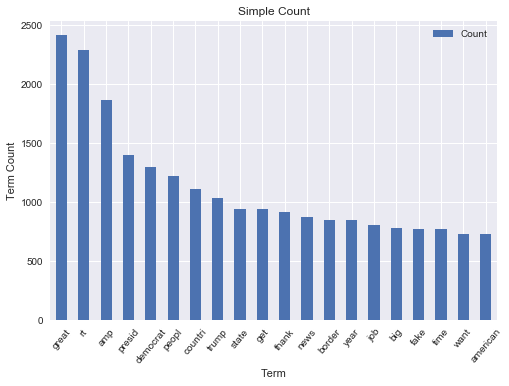

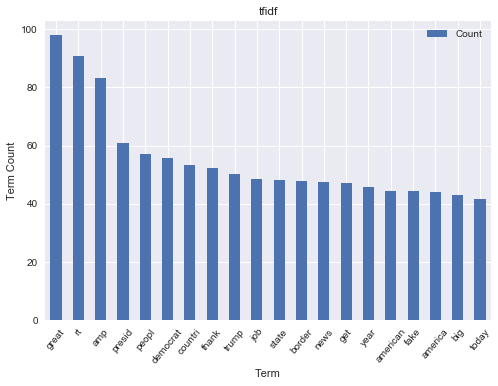

In [28]:
topn=20
Count.head(topn).set_index('Term').plot(kind='bar')
plt.xticks(rotation=50)
plt.xlabel("Term")
plt.ylabel("Term Count")
plt.title('Simple Count');

CountTfidf.head(topn).set_index('Term').plot(kind='bar')  # Already sorted
plt.xticks(rotation=50)
plt.xlabel("Term")
plt.ylabel("Term Count")
plt.title('tfidf');

## Q1

As demonstrated by the bar charts above, in both simple-count weighting and tfidf weighting, the most common word in Trump's tweets was "great". 'rt', abbreviation of 'retweet' ranked second, as Trump was fond of encouraging others to retweet his post. Other noticeable terms included 'border', 'fake' and 'news', highlighting his iconic project and feud with media. Somewhat amusingly, 'big' qualified as the 19th most frequent word. Trump's conversational, occasionally vulgar speaking style is not a novel subject.


## Sentiment Analysis with NLTK


## Q2
We utilized the Harvard-IV-Lasswell (`H4Lvd`) dictionary retrieved from [here](http://www.wjh.harvard.edu/~inquirer/homecat.htm). This is a dictionary augmented from Harvard-IV and Lasswell. Though there are a dozen of emotional categories in `H4Lvd`, we extracted only words from 'Positiv' and 'Negativ'.

We chose this dictionary because of its comprehensiveness and authority.
> The Harvard dictionary shown in the spreadsheet was expanded in 1998 to include almost all words [...] that occur 4 or more times per million according to the Thorndyke-Lorge counts.

Compared to Loughran-McDonald dictionary, `H4Lvd` is more general-purpose rather than financially relavant. But since the president's tweets mostly do not refer to financials directly, a general dictionary fits our objective.

In [29]:
####################################################################################
DICT_PATH = 'inquireraugmented.xls'
sentiment_dict = pd.read_excel(DICT_PATH, dtype=dict(Entry=str))
# Select entries from Havard-IV & Lasswell
sentiment_dict = sentiment_dict[sentiment_dict.Source == 'H4Lvd']
sentiment_dict = sentiment_dict[['Entry', 'Positiv', 'Negativ']]
sentiment_dict = sentiment_dict.dropna(how='all', subset=['Positiv', 'Negativ'])

In [30]:
positive = sentiment_dict.Entry[~sentiment_dict.Positiv.isnull()]
negative = sentiment_dict.Entry[~sentiment_dict.Negativ.isnull()]

For some entries, the augumented spreadsheet appends '#..' to the same word to distinguish meanings in different dictionaries. We took care of that.

In [31]:
# Remove hash sign
positive = positive.map(lambda x: re.sub(r'#\S+', '', x))
negative = negative.map(lambda x: re.sub(r'#\S+', '', x))

Preprocess the dictionary as well. This is becase their website don't provide dictionary in stemmed format. Usually, we need to be careful about this step, since not all documents demand this revision. The dictionary in R, for example, has already been preprocessed into stemmed format.

In [32]:
print(positive[:10])
print(negative[:10])

9           ABILITY
11             ABLE
51        ABUNDANCE
52         ABUNDANT
59           ACCEDE
63           ACCEPT
64       ACCEPTABLE
65       ACCEPTANCE
74      ACCOMMODATE
75    ACCOMMODATION
Name: Entry, dtype: object
2      ABANDON
4        ABATE
12    ABNORMAL
14     ABOLISH
32      ABRUPT
34     ABSENCE
35      ABSENT
49      ABSURD
53       ABUSE
54       ABUSE
Name: Entry, dtype: object


In [33]:
#2. preprocess the dictionary
p_list = positive.map(lambda x: PorterStemmer().stem(x.strip()).lower()).unique()
n_list = negative.map(lambda x: PorterStemmer().stem(x.strip()).lower()).unique()

Then, we can operate the text data with **dictionary method**. Here, we chooce two different ways to normalize the sentiment. One is by effective length of the document; the other is by the number of sentiment count.

In [34]:
final

,Date,Transformed Text
0,2017-01-20,thank join us lincoln memori tonight special e...
1,2017-01-21,thank anoth wonder even washington c togeth ma...
2,2017-01-22,great meet cia headquart yesterday pack hous p...
3,2017-01-23,busi week plan heavi focu job nation secur top...
4,2017-01-24,meet top automobil execut concern job america ...
...,...,...
1007,2019-12-01,sen tim scott say trump innoc way senat convic...
1008,2019-12-02,donald trump frame back mariabartiromo correct...
1009,2019-12-03,true unit state america support brave peopl ir...
1010,2019-12-04,enjoy meet prime minist borisjohnson unit king...


In [35]:
score1=[]
score2=[]
for text in final['Transformed Text']:
    tokens = text.split(' ')
    pos = [word for word in tokens if word in p_list]
    neg = [word for word in tokens if word in n_list]
    pos_count = len(pos)
    neg_count = len(neg)
    try:
        score1.append((len(pos)-len(neg))/(len(pos)+len(neg)))  # Weighted by sentiment counts
    except ZeroDivisionError:
        score1.append(np.nan)
    score2.append(((len(pos)-len(neg))/len(tokens)))  # Weighted by total document count

x1 = list(daily_tweets.index)
sentiment_Frame=pd.DataFrame({'Date':x1,'Score1':score1,'Score2':score2})
sentiment_Frame

,Date,Score1,Score2
0,2017-01-20,0.619048,0.123810
1,2017-01-21,0.600000,0.260870
2,2017-01-22,0.333333,0.096154
3,2017-01-23,0.000000,0.000000
4,2017-01-24,0.230769,0.069767
...,...,...,...
1007,2019-12-01,0.428571,0.142857
1008,2019-12-02,0.282051,0.069328
1009,2019-12-03,0.333333,0.176471
1010,2019-12-04,0.612903,0.159664


## Q3
We constructed two scores to quantify the emotional positivity on a daily basis. Both scores are simple count-based measure. The higher the score, the more 'positively' Trump expresses.

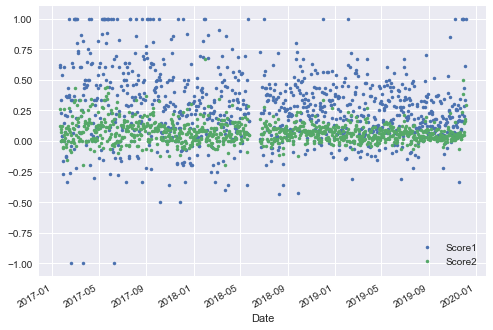

In [36]:
sentiment_Frame.set_index('Date').plot(style='.');

# VIX index
Trump has been famous for his obsessiveness to release disruptive information, opinion and decision on Twitter in a considerably real-time fashion. Those posts could have serious impact on investor confidence, business prospects and economic outlook. Ground-breaking posts such as those about US-China trade war might have agitated the market and geared up volatility. It comes natural to correlate the VIX "fear index" with his sentiment in tweets, trying to gauge if a more pessimistic Trump will stir investors' fear in a more uncertain economy.

In [37]:
from sklearn.preprocessing import StandardScaler
vix = pd.read_csv('VIX.csv',
                  parse_dates=['Date'])[['Adj Close',
                                         'Date']].rename(columns={'Adj Close': 'VIX'})
df = pd.merge(vix, sentiment_Frame, on='Date')

One thing to compare the trends is that the scale of the data could be completely different. To describle the trends, it's better to rescale the series.

In [38]:
df = df.set_index('Date')
df=df[['VIX','Score1', 'Score2']]
scaler = StandardScaler()
scaled_df = pd.DataFrame(data=scaler.fit_transform(df), index=df.index, columns=df.columns)
scaled_df

,VIX,Score1,Score2
Date,,,
2017-01-20,-0.693000,1.182124,0.577333
2017-01-23,-0.638904,-0.957431,-0.876617
2017-01-24,-0.803544,-0.159845,-0.057307
2017-01-25,-0.864696,-0.807161,-0.741635
2017-01-26,-0.907032,-0.829423,-0.765830
...,...,...,...
2019-11-29,-0.438985,2.498773,3.640091
2019-12-02,0.099623,0.017396,-0.062471
2019-12-03,0.346582,0.194637,1.195755


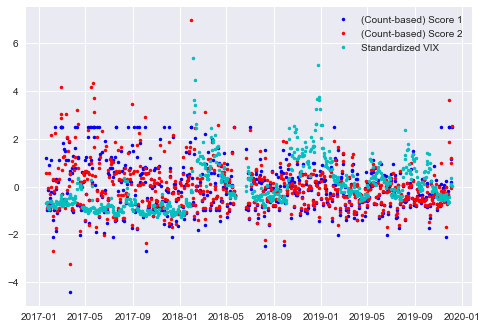

In [39]:
#3. Draw the graphs to show the sentiment trend
x1=scaled_df.index
y1=scaled_df['Score1']
y2=scaled_df['Score2']
y3=scaled_df['VIX']
plt.plot(x1,y1,'b.',label='(Count-based) Score 1')
plt.plot(x1,y2,'r.',label='(Count-based) Score 2')
plt.plot(x1,y3,'c.',label='Standardized VIX')
plt.legend()

In [40]:
# Compute correlation
scaled_df.corr()

,VIX,Score1,Score2
VIX,1.000000,-0.074808,-0.053889
Score1,-0.074808,1.000000,0.920736
Score2,-0.053889,0.920736,1.000000


In [41]:
# Significance test of the correlation coefficient
def corr_p_value(r, N):
    t = r * np.sqrt(N-2) / np.sqrt(1 - r**2)  # Test statistics, conforming to student-t distribution
    return 2*t_dist.cdf(t, df=N-2)

In [42]:
r = scaled_df.corr().loc['VIX', ['Score1', 'Score2']]
p = corr_p_value(r, scaled_df.shape[0])
p

array([0.04771507, 0.15407559])

## Q4
The correlations between daily VIX levels and two simple count-based metrics are -7.5% and -5.3%. The corresponding two-tail p-values are 0.04771507 and 0.15407559. Hence, at 95% confidence level, the correlation is significance under Score 1 metric but not under Score 2 metric.

The negative sign is what we expected: the more pessimistic and aggressive Trump gets, the more unsettled the market becomes.

## `tfidf` term weighting
- Sum up the `tfidf`-weighted frequencies of terms in two categories: 'Positiv' and 'Negativ'
- Normalize the differential by document term count

In [43]:
data = final.set_index('Date').loc[df.index]
data['wordCount'] = data['Transformed Text'].map(lambda x: len(x.split(' ')))
tfidf=TfidfVectorizer(stop_words=stopwords.words('english'))
tfidf2=tfidf.fit_transform(list(data['Transformed Text'].values))

In [44]:
positive_mask = np.zeros(shape=len(tfidf.get_feature_names()))
negative_mask = np.zeros(shape=len(tfidf.get_feature_names()))
positive_bool = list(map(lambda x: x in p_list, tfidf.get_feature_names()))
negative_bool = list(map(lambda x: x in n_list, tfidf.get_feature_names()))
positive_mask[positive_bool] = 1
negative_mask[negative_bool] = 1

In [45]:
positive_values = np.dot(tfidf2.toarray(), positive_mask)
negative_values = np.dot(tfidf2.toarray(), negative_mask)
sentiment_scores = (positive_values - negative_values) / data.wordCount.values

In [46]:
tfidf_summary = pd.merge(pd.DataFrame(dict(Date=df.index, score=sentiment_scores)),
                         vix,
                         on='Date').set_index('Date')
tfidf_summary = pd.DataFrame(scaler.fit_transform(tfidf_summary.values),
                             index=tfidf_summary.index,
                             columns=tfidf_summary.columns)
tfidf_summary.rename(columns=dict(VIX='Standardized VIX', score='tfidf Score'), inplace=True)

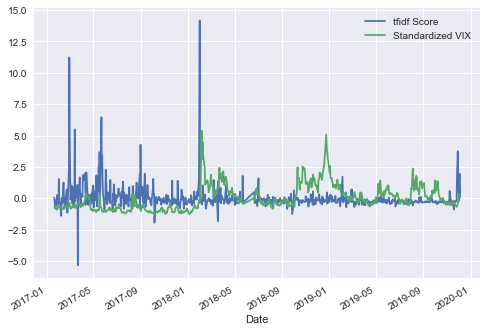

In [47]:
tfidf_summary.plot();

In [48]:
tfidf_summary.corr()

,tfidf Score,Standardized VIX
tfidf Score,1.000000,-0.081532
Standardized VIX,-0.081532,1.000000


In [49]:
r = tfidf_summary.corr().iloc[0, 1]
p = corr_p_value(r, tfidf_summary.shape[0])
print('p-value = {:.4f}'.format(p))

p-value = 0.0309


## Q5
Using the same setup, but with `tfidf` term weighting, the correlation increases to -8.2%, stilling passing the test at 95% C.I. The sign remains negative. Our conclusions do not change and we have stronger confidence in the significance of the relationship.